# Module 4.4 - CNN
link to original white paper: https://ip.cadence.com/uploads/901/cnn_wp-pdf

link to original post: http://cs231n.github.io/convolutional-networks/

## Lessons Learned
Implementing a CNN is unargubly one of the most fun experiences I've had in this summer class due to its intuitive nature and being able to visualize the operations. 

One thing I would improve if I were to implement a CNN again is to have fully connected layers and convolutional layers share the same inherentence. The reason is the difference between the two is minimum: everytime I change something in FC I have to do the same to conv layers. 

The filters learned in project are quite interesting. At a first glance, they seem to have a tendency turn the image to negative in the first conv layer, so that the negative spaces in the input become areas of high activations. It is actually not the case: after calculating the abs val of the first conv layer output, we can see the numbers remain to be areas of high activation, though the activations are negative. However, in this task, it doesn't really matter if the network uses the negative or positive space to classify since they have about the same amount of predictive power. 

In [1]:
import numpy as np
np.random.seed(42)
from tqdm import tqdm
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline

/Users/macbook/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1120: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #41
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Users/macbook/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'ps', u'Qt4Agg', u'GTK', u'GTKAgg', u'nbAgg', u'agg', u'cairo', u'MacOSX', u'GTKCairo', u'Qt5Agg', u'template', u'WXAgg', u'TkAgg', u'GTK3Cairo', u'GTK3Agg', u'svg', u'WebAgg', u'pdf', u'gdk', u'WX']
  (val, error_details, msg))


## Introduction
A CNN is a special case of artificial neural networks. CNNs usually are consisted of one or more convolutional layers,  often with a subsampling layer, and followed by one or more fully connected layers. 

## Theory
The design of CNN is inspired by the discovery of the visual mechnism found in the visual cortex of the brain. The visual cortex is responsible for detecting light in small, overlapping sub-regoins, called the "receptive fields". They act as filters for local features in the input such as corners, edges, and etc. In CNN, convolutional layers play the role of the cortex: the inputs are recieved by local receptive fields to extract elementary visual features. The features extraction process traditionally are done by hand. On the other hand, it is done through the training process in CNNs. Last in the training process, a classifer predicts the label for the image. 

## Layers
A ConvNet is made up of Layers. Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters.

There are three main types of layers: Convolutional Layer, Pooling Layer, and Fully-Connected Layer. We stack them to build a full CNN. 

### Convolutional layers
#### Sptial Arrangement
There are three hyperparameters controls the output shape and arrangement: 
1. Depth (F): the number of filters. Neurons in each filter may represent things like oriented edges, or blobs of color. We will refer to a set of neurons that are all looking at the same region of the input as a depth column (some people also prefer the term fibre).
2. Stride (S): how much we move the filters each time. Stride of 1 means to move filter 1 unit at a time. Note that the larger the stride the smaller the output volume. Sometimes, strides may not "fit", meaning the output doesn't have a integer size: we use zero-padding to solve it. 
3. Zero-padding (S): This allows us to control the spaial size of the output, especially when we want to perserve the size of the input. 

The output size is given by $O = (W−F+2P)/S + 1$, $W$ is the width of input.

#### Parameter Sharing
For each filter, the weights and bias are shared within the depth. Say if the receptive field (depth) is 11, and the the input is 3 units deep and there are 96 filters. Then we have $11 * 11 * 3 * 96 + 96 = 34,944$ weights (including bias). 

Notice that if all neurons in a single depth slice are using the same weight vector, then the forward pass of the CONV layer can in each depth slice be computed as a convolution of the neuron’s weights with the input volume (Hence the name: Convolutional Layer). 

In that case it is common to relax the parameter sharing scheme, and instead simply call the layer a Locally-Connected Layer.

#### 1 * 1 Convolutions
Normally, $1 * 1$ convolutions is simply scaling of a matrix. However, in our 3D case, a $1 * 1$ convolution changes (W, H, D) sized input to (W, H, K) sized output. Effectively, such convolution does not take spatial information into account, but it takes the depth informtion into accuont. In addtion, it can be used to reduce the number of weights in the network.

#### Dilated convolutions
In addition to receptive field, stride, padding, you can add dilation to your convolution. In convolution, if dilation of D is introduced, there would be an offset of D between each input dotted with the corresponding weight. For example, for an one dimensional filter of size 3, with D = 1, the result is $w[0]*x[0] + w[1]*x[2] + w[2]*x[4]$

#### Summary 
For an input image size of (W1, H1, D1), receptive field F, zero-padding P, stride S, number of filters K, we have the output sized 
1. $W2 = (W1 + 2P - F) / S + 1 $
2. $H2 = (H1 + 2P - F) / S + 1$
3. $D2 = K$

It introduces a number of parameters. For each filter, there are $F * F * D1$ weights. In total, there are $F * F * D1 * K$ weights and $K$ biases. 

#### Implementation

In [2]:
X = np.random.uniform(-1, 1, (227, 227, 3))
W = np.random.uniform(-1, 1, (11, 11, 3, 96))

In [3]:
# hyper params
S = 4
P = 0
F = 11
K = 96

assert (X.shape[0] + 2.0 * P - F) / S % 1 == 0
assert (X.shape[1] + 2.0 * P - F) / S % 1 == 0

H2 = (X.shape[0] + 2 * P - F) / S + 1
W2 = (X.shape[1] + 2 * P - F) / S + 1



print "New height will be: " + str(H2)
print "New width will be: " + str(W2)

New height will be: 55
New width will be: 55


In [4]:
# sliding window
def im2col(X, S, F):
    # new size
    assert X.shape[0] == X.shape[1]
    W2 = (X.shape[0] - F) / S + 1
    # depth
    D = X.shape[2]
    # output
    X_col = np.zeros((F * F * D, W2 * W2))
    
    # slide the window
    X_col_ind = 0
    for i in range(W2):
        for j in range(W2):
            X_col[:, X_col_ind] = np.reshape(np.ravel(X[i*S:i*S+F, j*S:j*S+F, :]), (F * F * D))
            X_col_ind += 1
    return X_col

In [5]:
# expend weights
def im2row(W):
    n = W.shape[0] * W.shape[1] * W.shape[2]
    W_row = np.zeros((W.shape[3], n))
    for k in range(W.shape[3]):
        W_row[k] = np.reshape(np.ravel(W[:, :, :, k]), (n))
    return W_row

In [6]:
X_col = im2col(X, S, F)
W_row = im2row(W)

print "New input shape: " + repr(X_col.shape)
print "New weight shape: " + repr(W_row.shape)

New input shape: (363, 3025)
New weight shape: (96, 363)


In [7]:
res_raw = np.dot(W_row, X_col)
print "Raw output shape: " + repr(res_raw.shape)

Raw output shape: (96, 3025)


In [8]:
res = np.reshape(np.ravel(res_raw), (H2, W2, K))
print "Output shape: " + repr(res.shape)

Output shape: (55, 55, 96)


### Pooling layers
Pooling layers are commonly placed in between conv layers. It progressivly reduces the spatial size of the input, which in turn reduces the numebr of paramters and computations of the network. It reduces the chance of over-fitting.
#### Maxpooling
Maxpooling involves stride paramter S and receptive field F. The pooling layer operates independently on every depth slice of the input and resizes it sptially by taking the MAX within each receptive fields. 

Most commonly, people use filter size of $2 * 2$ and stride of 2. 

Following is an illustration of Maxpooling:

![Maxpooling](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

#### Backpropagation
For maxpooling, since the output only depend on the input that activated the max function, we can simply back prop by passing the gradient through that input. Therefore it is common to keep track of the index of those inputs. 

#### Summary
For an input image size of (W1, H1, D1), receptive field F, stride S, we have the output sized 
1. $W2 = (W1 - F) / S + 1 $
2. $H2 = (H1 - F) / S + 1$
3. $D2 = D1$

It is not common to use zero-padding.

#### Implementation
Similar to conv layers, we use im2col for maxpooling. 

In [9]:
def maxpool_without_index(X, S, F):
    # new size
    assert X.shape[0] == X.shape[1]
    W2 = (X.shape[0] - F) / S + 1
    # depth
    D = X.shape[2]
    # X_col that's kept depth-independent
    X_col = np.zeros((F * F, W2 * W2, X.shape[2]))
    for d in range(D):
        X_col_ind = 0
        # slide the window
        for i in range(W2):
            for j in range(W2):
                X_col[:, X_col_ind, d] = np.reshape(np.ravel(X[i*S:i*S+F, j*S:j*S+F, d]), (F * F))
                X_col_ind += 1
    # big matrix operation
    X_max_pool = np.max(X_col, axis = 0)
    X_max_pool = np.reshape(np.ravel(X_max_pool), (W2, W2, D))
    return X_max_pool

In [10]:
X_max_pool = maxpool_without_index(res, 5, 5)

In [11]:
print "Output shape: " + repr(X_max_pool.shape)

Output shape: (11, 11, 96)


### Fully connected layers
Fully connected layers are in a way, special convolutional layers. For example, say we have input of $(256 * 256 * 200)$. We have, say, 20 kernal sized $(256 * 256 * 200)$ with stride 1, padding 0, and (of course) receptive field 256. Then such a kernal's convolution is the same of having full connection. The result would be $(1 * 1 * 20)$. 

In [12]:
weights = np.random.rand(11, 11, 96, 200)
kernal = im2row(weights)
X_col = im2col(X_max_pool, 1, 11)
res_raw = np.dot(kernal, X_col)
res = np.reshape(np.ravel(res_raw), (1, 1, 200))

In [13]:
print kernal.shape
print X_col.shape
print "Output shape:" + repr(res.shape)

(200, 11616)
(11616, 1)
Output shape:(1, 1, 200)


## Architecture
### Layer Patterns
Note: the RELU activation function is written as a layer, which applies elementwise non-linearity
Common pattern:

$INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC$

where $N >= 0$ (and usually $N <= 3$), $M >= 0$, $K >= 0$ (and usually $K < 3$)

We prefer a stack of small kernals to one large kernel. Since the former can express non-linear features with fewer parameters. 

### Layer Sizing Patterns
Input layers are usually sized such that it's divisiable by 2. Common numbers include 32 (e.g. CIFAR-10), 64, 96 (e.g. STL-10), or 224 (e.g. common ImageNet ConvNets), 384, and 512.

The conv layers should be using small filters (e.g. 3x3 or at most 5x5), using a stride of $S = 1$, and crucially, padding the input volume with zeros in such way that the conv layer does not alter the spatial dimensions of the input. That is, when $F = 3$, then using $P = 1$ will retain the original size of the input. Bigger sizes are common to see this on the very first conv layer that is looking at the input image.

The pool layers are in charge of downsampling the spatial dimensions of the input. The most common setting is to use max-pooling with 2x2 receptive fields (i.e. $F = 2$), and with a stride of 2 (i.e. $S = 2$). 

### Other notes
*Why use padding?* 

In addition to the aforementioned benefit of keeping the spatial sizes constant after CONV, doing this actually improves performance. If the CONV layers were to not zero-pad the inputs and only perform valid convolutions, then the size of the volumes would reduce by a small amount after each CONV, and the information at the borders would be “washed away” too quickly.

*Compromising based on memory constraints*

In some cases (especially early in the ConvNet architectures), the amount of memory can build up very quickly with the rules of thumb presented above. For example, filtering a 224x224x3 image with three 3x3 CONV layers with 64 filters each and padding 1 would create three activation volumes of size [224x224x64]. This amounts to a total of about 10 million activations, or 72MB of memory (per image, for both activations and gradients). Since GPUs are often bottlenecked by memory, it may be necessary to compromise. In practice, people prefer to make the compromise at only the first CONV layer of the network. For example, one compromise might be to use a first CONV layer with filter sizes of 7x7 and stride of 2 (as seen in a ZF net). As another example, an AlexNet uses filter sizes of 11x11 and stride of 4.

## Full Implementation

In [14]:
# make sure the debugging code doesn't get executed
isDebugging = False

In [15]:
def zero_pad(X, P):
    H = X.shape[0]
    W = X.shape[1]
    D = X.shape[2]
    X = np.vstack((np.zeros((P,H,D)), X))
    X = np.vstack((X, np.zeros((P,H,D))))
    X = np.hstack((np.zeros((W + 2 * P, P,D)), X))
    X = np.hstack((X, np.zeros((W + 2 * P, P,D))))
    return X

In [16]:
def depad(X, P):
    X = X[P:-P,P:-P,:]
    return X

In [17]:
def get_new_size(W1, P, F, S):
    return (W1 + 2.0 * P - F) / S + 1.0

In [18]:
def col2im(X_col, S, D):
    assert np.sqrt(X_col.shape[0] / D) % 1 == 0
    assert np.sqrt(X_col.shape[1]) % 1 == 0
    
    # calculate dims
    F = int(np.sqrt(X_col.shape[0] / D))
    W2 = int(np.sqrt(X_col.shape[1]))
    W1 = (W2 - 1) * S + F
    
    X_recover = np.zeros((W1, W1, D))
    
    X_col_ind = 0
    # slide the window
    for i in range(W2):
        for j in range(W2):
            # in case of overlapping receptive fields, we accumulate rather than assign
            X_recover[i*S:i*S+F, j*S:j*S+F, :] += np.reshape(np.ravel(X_col[:, X_col_ind]), (F, F, D))
            X_col_ind += 1
    return X_recover

In [19]:
def row2im(W_row, D):
    F = np.sqrt(W_row.shape[1] / D)
    assert F % 1 == 0
    F = int(F)
    K = W_row.shape[0]
    W = np.zeros((F, F, D, K))
    for k in range(K):
        W[:,:,:,k] = np.reshape(W_row[k], (F, F, D))
    return W

In [20]:
def convolve(X, W, S = 1, P = 0, auto_padding = False):
    assert len(X.shape) == 3
    assert len(W.shape) == 4
    assert X.shape[2] == W.shape[2]
    assert W.shape[0] == W.shape[1]
    assert S > 0
    assert P >= 0
    
    W1 = X.shape[0]
    F = W.shape[0]
    K = W.shape[3]
    
    # auto padding by incrementing P
    if auto_padding:
        P = 0
        while not get_new_size(W1, P, F, S) % 1 == 0:
            if P == W1:
                print "Warning: padding getting larger than input..."
            P += 1
            
    # non-auto-padding check
    assert get_new_size(W1, P, F, S) % 1 == 0
    
    # zero padding
    if P > 0:
        X = zero_pad(X, P)
    
    # the new size
    W2 = int(get_new_size(W1, P, F, S))
    
    # fast matrix stuff
    X_col = im2col(X, S, F)
    W_row = im2row(W)
    res_raw = np.dot(W_row, X_col)
    
    # change aug 15: 18:55: reshape was doing the reshaping wrong...
    res = np.zeros((W2, W2, K))
    for k in range(K):
        res[:,:,k] = np.reshape(np.ravel(res_raw[k]), (W2, W2))
        
    return res
    

In [21]:
def deconvolve(X_conv, W, S):
    assert len(X_conv.shape) == 3
    assert len(W.shape) == 4
    assert W.shape[0] == W.shape[1]
    assert X_conv.shape[0] == X_conv.shape[1]
    assert S > 0
    
    D = W.shape[2]
    F = W.shape[0]
    K = W.shape[3]
    W2 = X_conv.shape[0]
    
    # fast matrix stuff
    W_row = im2row(W)
    # reshape it for deconvolve
    X_conv_col_shaped = np.zeros((K, W2 * W2))
    for k in range(K):
        X_conv_col_shaped[k, :] = np.reshape(np.ravel(X_conv[:,:,k]), (W2 * W2))
    X_col = np.dot(W_row.T, X_conv_col_shaped)
    X_recover = col2im(X_col, S, D)
    
    return X_recover

In [22]:
def maxpool(X, S, F):
    # new size
    assert X.shape[0] == X.shape[1]
    W2 = (X.shape[0] - F) / S + 1
    # depth
    D = X.shape[2]
    # X_col that's kept depth-independent
    X_col = np.zeros((F * F, W2 * W2, X.shape[2]))
    for d in range(D):
        X_col_ind = 0
        # slide the window
        for i in range(W2):
            for j in range(W2):
                X_col[:, X_col_ind, d] = np.reshape(np.ravel(X[i*S:i*S+F, j*S:j*S+F, d]), (F * F))
                X_col_ind += 1
    # big matrix operation
    X_max_pool = np.max(X_col, axis = 0)
    X_max_pool = np.reshape(np.ravel(X_max_pool), (W2, W2, D))
    X_max_index = np.argmax(X_col, axis = 0)
    X_col_max_recover = np.zeros_like(X_col)
    
    return X_max_pool, X_max_index, X_col_max_recover

In [23]:
def upsample(X_max_index, X_col_max_recover, S, outgrad):
    assert np.sqrt(X_col_max_recover.shape[1]) == outgrad.shape[0]
    assert np.sqrt(X_col_max_recover.shape[1]) == outgrad.shape[1]
    assert X_col_max_recover.shape[2] == outgrad.shape[2]
    
    # calculate dimensions
    F = np.sqrt(X_col_max_recover.shape[0])
    assert F % 1 == 0
    F = int(F)
    
    D = X_col_max_recover.shape[2]
    W2 = outgrad.shape[0]
    W1 = (W2 - 1) * S + F
    
    # flatten the gradients
    outgrad = np.ravel(outgrad, (np.prod(outgrad.shape)))
    
    # put gradients in the correct position of the col vector
    grad_idx = 0
    for d in range(X_col_max_recover.shape[2]):
        for i in range(X_col_max_recover.shape[1]):
            X_col_max_recover[X_max_index[i, d], i, d] = outgrad[grad_idx]
            grad_idx += 1
    # recover the shape of X and put gradients at the correct spots
    X_recover = np.zeros((W1, W1, D))
    for d in range(D):
        X_col_ind = 0
        # slide the window
        for j in range(W2):
            for i in range(W2):
                # in case of overlapping receptive fields, we accumulate rather than assign
                X_recover[i*S:i*S+F, j*S:j*S+F, d] += np.reshape(np.ravel(X_col_max_recover[:, X_col_ind, d]), (F, F))
                X_col_ind += 1
    
    return X_recover

### Layers

In [24]:
class ConvolutionalLayer(object):
    def __init__(self, W, b, S, P = 0):
        self.W = W
        self.S = S
        self.P = P
        self.F = W.shape[0]
        self.b = b
        self.param_grad = np.zeros_like(W)
        self.bias_grad = np.zeros_like(b)
        self.accum_count = 0
        
        # momentum
        self.param_update = np.zeros_like(W)
        self.bias_update = np.zeros_like(b)
        
        # adam
        self.t = 0
        self.w_m = np.zeros_like(W)
        self.w_v = np.zeros_like(W)
        self.b_m = np.zeros_like(b)
        self.b_v = np.zeros_like(b)
        
        # check bias shape
        assert len(self.b.shape) == 1
        assert self.b.shape[0] == self.W.shape[3]
        
    def get_nb_of_params(self):
        return np.prod(self.W.shape)
    
    def __str__(self):
        return "(Conv: " + repr(self.get_nb_of_params()) + ")"
        
    def forward(self, X):
        #[K, F * F * D] * [F * F * D, W2 * W2] = [K, W2 * W2]
        self.X = zero_pad(X, self.P)
        return convolve(X, self.W, self.S, self.P) + self.b
    
    def backward(self, outgrad):
        # for bp
        res = deconvolve(outgrad, self.W, self.S)
        res = depad(res, self.P)
        # get param gradients
        param_grad = self.get_param_grad(outgrad)
        bias_grad = self.get_bias_grad(outgrad)
        self.accumulate_grads(param_grad, bias_grad)
        return res  
    
    def update_all(self, lr):
        ''' 
        # gradient desecent
        self.W -= self.param_grad * lr
        self.b -= self.bias_grad * lr
        '''
        '''
        # with momentum
        global momentum
        
        param_momentum = self.param_update * momentum
        b_momentum = self.bias_update * momentum
        
        self.param_update = - self.param_grad * lr + param_momentum
        self.bias_update = - self.bias_grad * lr + b_momentum
        
        self.W += self.param_update 
        self.b += self.bias_update 
        '''
        
        # adam
        global eps, beta_1, beta_2
        self.t += 1
        
        self.param_grad /= self.accum_count
        self.bias_grad /= self.accum_count
        
        # weights
        self.w_m = beta_1 * self.w_m + (1 - beta_1) * self.param_grad
        self.w_v = beta_2 * self.w_v + (1 - beta_2) * self.param_grad ** 2
        w_m_corr = self.w_m / (1 - beta_1 ** self.t)
        w_v_corr = self.w_v / (1 - beta_2 ** self.t)
        # bias
        self.b_m = beta_1 * self.b_m + (1 - beta_1) * self.bias_grad
        self.b_v = beta_2 * self.b_v + (1 - beta_2) * self.bias_grad ** 2
        b_m_corr = self.b_m / (1 - beta_1 ** self.t)
        b_v_corr = self.b_v / (1 - beta_2 ** self.t)
        # update
        self.W = self.W - lr * w_m_corr / (np.sqrt(w_v_corr) + eps)
        self.b = self.b - lr * b_m_corr / (np.sqrt(b_v_corr) + eps)
        
        self.reset_grads()
        
    def get_param_grad(self, outgrad):
        X_col = im2col(self.X, self.S, self.F)
        K = outgrad.shape[2]
        W2 = outgrad.shape[0]
        D = self.X.shape[2]
        #outgrad = np.reshape(np.ravel(outgrad), (K, W2 * W2))
        # reshape the outgrad for computation
        outgrad_reshaped = np.zeros((K, W2 * W2))
        for k in range(K):
            outgrad_reshaped[k,:] = np.reshape(np.ravel(outgrad[:,:,k]), (W2 * W2))
        param_grad = np.dot(outgrad_reshaped, X_col.T)
        return row2im(param_grad, D) / (W2 ** 2)
    
    def get_bias_grad(self, outgrad):
        W2 = outgrad.shape[0]
        grad_axes = tuple(range(len(outgrad.shape)-1))
        return np.sum(outgrad, axis = grad_axes) / (W2 ** 2)
        
    def accumulate_grads(self, param_grad, bias_grad):
        self.param_grad += param_grad
        self.bias_grad += bias_grad
        self.accum_count += 1
    
    def reset_grads(self):
        self.param_grad = np.zeros_like(self.W)
        self.b_grad = np.zeros_like(self.b)
        self.accum_count = 0

In [25]:
class MaxpoolingLayer(object):
    def __init__(self, S, F):
        self.S = S
        self.F = F
        
    def get_nb_of_params(self):
        return 0
    
    def __str__(self):
        return "(Maxpool)"
        
    def forward(self, X):
        mp, self.idx, self.rec = maxpool(X, self.S, self.F)
        return mp
    
    def backward(self, outgrad):
        return upsample(self.idx, self.rec, self.S, outgrad)
    
    def update_all(self, lr):
        pass

In [26]:
class ReLU(object):
    def get_nb_of_params(self):
        return 0
    
    def __str__(self):
        return "(ReLU)"
    
    def forward(self, X):
        self.Y = np.maximum(X, 0.0)
        return self.Y
    
    def backward(self, outgrad):
        try:
            assert (self.Y >= 0).all()
        except:
            print self.Y
        assert self.Y.shape == outgrad.shape
        
        Y_step = np.minimum(np.ceil(self.Y), 1.0)
        return np.multiply(outgrad, Y_step)
    
    def update_all(self, lr):
        pass

In [27]:
class Leaky_ReLU(object):
    def __init__(self):
        self.leaky_slope = 0.1
    
    def get_nb_of_params(self):
        return 0
    
    def __str__(self):
        return "(Leaky ReLU)"
    
    def forward(self, X):
        self.Y = np.maximum(X, self.leaky_slope * X)
        return self.Y
    
    def backward(self, outgrad):
        assert self.Y.shape == outgrad.shape
        
        Y_step = np.maximum(self.Y, 0.0)
        Y_step = np.minimum(np.ceil(Y_step), 1.0)
        Y_step *= 1.0 - self.leaky_slope
        Y_step += self.leaky_slope
        
        return np.multiply(outgrad, Y_step)
    
    def update_all(self, lr):
        pass

In [28]:
class FullyConnnectedLayer(object):
    def __init__(self, W, b, S):
        self.W = W
        self.b = b
        self.S = S
        self.F = self.W.shape[0]
        self.param_grad = np.zeros_like(W)
        self.bias_grad = np.zeros_like(b)
        self.accum_count = 0
        
        # momentum
        self.param_update = np.zeros_like(W)
        self.bias_update = np.zeros_like(b)
        
        # adam
        self.t = 0
        self.w_m = np.zeros_like(W)
        self.w_v = np.zeros_like(W)
        self.b_m = np.zeros_like(b)
        self.b_v = np.zeros_like(b)
        
        # check bias shape
        assert len(self.b.shape)
        assert self.b.shape[0] == 1
        
        
    def __str__(self):
        return "(FC: " + repr(self.get_nb_of_params()) + ")"
    
    def get_nb_of_params(self):
        return np.prod(self.W.shape) + np.prod(self.b.shape)
    
    def forward(self, X):
        assert self.W.shape[0:3] == X.shape[0:3]
        self.X = X
        return convolve(X, self.W, self.S) + self.b
        
    def backward(self, outgrad):
        # for bp
        res = deconvolve(outgrad, self.W, self.S)
        # get param gradients
        param_grad = self.get_param_grad(outgrad)
        bias_grad = self.get_bias_grad(outgrad)
        self.accumulate_grads(param_grad, bias_grad)
        return res  
    
    def update_all(self, lr):
        ''' 
        # gradient desecent
        self.W -= self.param_grad * lr
        self.b -= self.bias_grad * lr
        '''
        '''
        # with momentum
        global momentum
        
        param_momentum = self.param_update * momentum
        b_momentum = self.bias_update * momentum
        
        self.param_update = - self.param_grad * lr + param_momentum
        self.bias_update = - self.bias_grad * lr + b_momentum
        
        self.W += self.param_update 
        self.b += self.bias_update 
        '''
        # adam
        global eps, beta_1, beta_2
        self.t += 1
        
        self.param_grad /= self.accum_count
        self.bias_grad /= self.accum_count
        
        # weights
        self.w_m = beta_1 * self.w_m + (1 - beta_1) * self.param_grad
        self.w_v = beta_2 * self.w_v + (1 - beta_2) * self.param_grad ** 2
        w_m_corr = self.w_m / (1 - beta_1 ** self.t)
        w_v_corr = self.w_v / (1 - beta_2 ** self.t)
        # bias
        self.b_m = beta_1 * self.b_m + (1 - beta_1) * self.bias_grad
        self.b_v = beta_2 * self.b_v + (1 - beta_2) * self.bias_grad ** 2
        b_m_corr = self.b_m / (1 - beta_1 ** self.t)
        b_v_corr = self.b_v / (1 - beta_2 ** self.t)
        # update
        self.W = self.W - lr * w_m_corr / (np.sqrt(w_v_corr) + eps)
        self.b = self.b - lr * b_m_corr / (np.sqrt(b_v_corr) + eps)
        
        self.reset_grads()
    
    def get_param_grad(self, outgrad):
        X_col = im2col(self.X, self.S, self.F)
        K = outgrad.shape[2]
        W2 = outgrad.shape[0]
        D = self.X.shape[2]
        #outgrad = np.reshape(np.ravel(outgrad), (K, W2 * W2))
        # reshape the outgrad for computation
        outgrad_reshaped = np.zeros((K, W2 * W2))
        for k in range(K):
            outgrad_reshaped[k,:] = np.reshape(np.ravel(outgrad[:,:,k]), (W2 * W2))
        param_grad = np.dot(outgrad_reshaped, X_col.T)
        return row2im(param_grad, D)
    
    def get_bias_grad(self, outgrad):
        # there is only one bias, sum everything
        return np.sum(outgrad)
        
    def accumulate_grads(self, param_grad, bias_grad):
        self.param_grad += param_grad
        self.bias_grad += bias_grad
        self.accum_count += 1
    
    def reset_grads(self):
        self.param_grad = np.zeros_like(self.W)
        self.bias_grad = np.zeros_like(self.b)
        self.accum_count = 0

In [29]:
class SoftmaxLayer(object):
    def __str__(self):
        return "(Softmax)"
    
    def get_nb_of_params(self):
        return 0
    
    def forward(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=2, keepdims=True)
    
    def backward(self, Y, T):
        return Y - T
    
    def get_cost(self, Y, T):
        return - np.multiply(T, np.log(Y)).sum()
    
    def update_all(self, lr):
        pass

### CNN

In [104]:
class ConvNet(object):
    def __init__(self):
        self.graph = [ConvolutionalLayer(np.random.uniform(-0.1, 0.1, (3, 3, 1, 10)), np.random.uniform(-0.1, 0.1, (10)), 1, 1),\
                      Leaky_ReLU(),\
                      ConvolutionalLayer(np.random.uniform(-0.1, 0.1, (3, 3, 10, 10)), np.random.uniform(-0.1, 0.1, (10)), 1, 1),\
                      Leaky_ReLU(),\
                      MaxpoolingLayer(2, 2),\
                      FullyConnnectedLayer(np.random.uniform(-0.1, 0.1, (4, 4, 10, 10)), np.random.uniform(-0.1, 0.1, (1)), 1), \
                      SoftmaxLayer()
                    ]
        
        print "Computation graph ready."
        print ""
      
    def get_nb_of_params(self):
        nb_of_params = 0
        for n in self.graph:
            nb_of_params += n.get_nb_of_params()
        return nb_of_params
    
    def get_nb_of_layers(self):
        return len(self.graph)
    
    def get_graph_repr(self):
        res = "(input)"
        for n in self.graph:
            res += "-->" + str(n)
        res += "-->(output)"
        return res
    
    def forward(self, X):
        Z = X
        for n in self.graph:
            Z = n.forward(Z)
        return Z
    
    def get_cost(self, Y, T):
        return self.graph[-1].get_cost(Y, T)
    
    def backward(self, Y, T):
        Z = Y
        for n in reversed(self.graph):
            if str(n) == "(Softmax)":
                Z = n.backward(Z, T)
            else:
                Z = n.backward(Z)
        return Z
    
    def update_all(self, lr):
        global momentum
        momentum = 0.0
        for n in self.graph:
            n.update_all(lr)
            
    
    def print_info(self):
        print "Total number of parameters: " + repr(self.get_nb_of_params())
        print "Total number of layers: " + repr(self.get_nb_of_layers())
        print "Graph: " + repr(self.get_graph_repr())
        

In [105]:
conv = ConvNet()
conv.print_info()

Computation graph ready.

Total number of parameters: 2591
Total number of layers: 7
Graph: '(input)-->(Conv: 90)-->(Leaky ReLU)-->(Conv: 900)-->(Leaky ReLU)-->(Maxpool)-->(FC: 1601)-->(Softmax)-->(output)'


### Try Dataset

In [106]:
from sklearn import datasets, model_selection, utils

In [107]:
digits = datasets.load_digits()
T = np.zeros((digits.target.shape[0], 10))
T[[np.arange(len(T))], digits.target] = 1
X_train, X_test, T_train, T_test = model_selection.train_test_split(digits.data, T, test_size = 0.4)

In [108]:
print X_train.shape
print X_test.shape

(1078, 64)
(719, 64)


In [109]:
X_train = np.reshape(np.ravel(X_train),(X_train.shape[0], int(np.sqrt(X_train.shape[1])), int(np.sqrt(X_train.shape[1])), 1))
T_train = np.reshape(np.ravel(T_train), (T_train.shape[0],1,1,T_train.shape[1]))

[[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]]


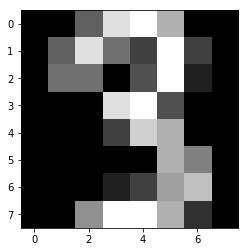

In [189]:
#print X[0]
print T_train[120]
plt.imshow(X_train[120, :, :, 0], cmap="gray") 
plt.show()

In [111]:
# initial error on the first sample
y = conv.forward(X_train[0])
print conv.get_cost(y, T_train[0])

2.28982872684


In [112]:
costs = []

In [113]:
epoches = 23
nb_of_mini_batch = 7
mini_batch_size = X_train.shape[0] / nb_of_mini_batch

In [114]:
lr = 0.1
global eps, beta_1, beta_2
eps= 1e-8
beta_1 = 0.9
beta_2 = 0.99

for e in tqdm(range(epoches)):
    # iterate through mini batches
    for i in range(nb_of_mini_batch):
        costs.append([0])
        # iterate through each sample in batch
        for j in range(mini_batch_size):
            idx = i * mini_batch_size + j
            y = conv.forward(X_train[idx])
            conv.backward(y, T_train[idx])
            costs[-1] += conv.get_cost(y, T_train[idx])
        # update new cost
        costs[-1] /= mini_batch_size
        '''
        if i == 17:
            plt.imshow(X_train[idx,:,:,0], cmap='gray')
            plt.show()
            print T_train[idx]
            assert False
        '''
        # update params
        conv.update_all(lr)
    # regenerate training set
    X_train, T_train = utils.shuffle(X_train, T_train, random_state=42)

100%|██████████| 23/23 [03:53<00:00,  9.96s/it]


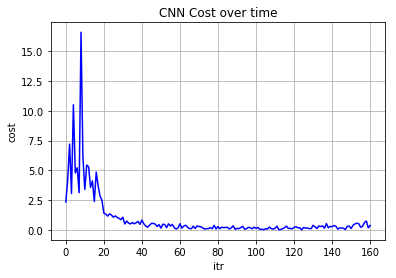

In [115]:
# plot learning curve
plt.plot(costs, 'b-')
plt.xlabel('itr')
plt.ylabel('cost')
plt.title('CNN Cost over time')
plt.grid()
plt.show()

In [116]:
# first 150 samples
idx = 150
for idx in range(100):
    act = conv.forward(X_train[idx])[0,0]
    nn = np.argmax(act)
    lab = np.argmax(T_train[idx,0,0])
    print str(idx) + ":\t" + str(nn) + " <- " + str(lab) + " " + repr(nn == lab) + "\t" + str(act[nn]) + "\t<- " + str(act[lab])

0:	8 <- 8 True	0.999996772043	<- 0.999996772043
1:	3 <- 3 True	0.99928654352	<- 0.99928654352
2:	9 <- 9 True	1.0	<- 1.0
3:	7 <- 7 True	1.0	<- 1.0
4:	3 <- 3 True	0.999999999994	<- 0.999999999994
5:	8 <- 8 True	0.999959541082	<- 0.999959541082
6:	2 <- 3 False	0.88821932264	<- 0.000252437774107
7:	8 <- 8 True	0.999999999951	<- 0.999999999951
8:	6 <- 6 True	1.0	<- 1.0
9:	6 <- 6 True	1.0	<- 1.0
10:	8 <- 8 True	0.999999894846	<- 0.999999894846
11:	1 <- 1 True	0.999797530406	<- 0.999797530406
12:	1 <- 1 True	0.999999996364	<- 0.999999996364
13:	2 <- 2 True	1.0	<- 1.0
14:	8 <- 8 True	0.999701067788	<- 0.999701067788
15:	4 <- 4 True	1.0	<- 1.0
16:	6 <- 6 True	1.0	<- 1.0
17:	1 <- 1 True	0.999999994532	<- 0.999999994532
18:	8 <- 8 True	0.999999999893	<- 0.999999999893
19:	2 <- 2 True	1.0	<- 1.0
20:	9 <- 9 True	1.0	<- 1.0
21:	7 <- 7 True	1.0	<- 1.0
22:	5 <- 5 True	0.999999999886	<- 0.999999999886
23:	7 <- 7 True	1.0	<- 1.0
24:	6 <- 6 True	1.0	<- 1.0
25:	5 <- 5 True	1.0	<- 1.0
26:	6 <- 6 True	1.0	<

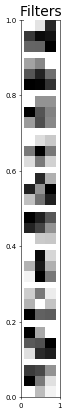

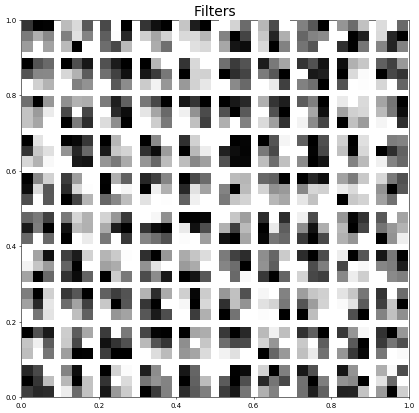

In [174]:
# the kernel looks like this
filters = conv.graph[0].W.shape[-1]
dims = conv.graph[0].W.shape[-2]

fig = plt.figure(figsize=(dims, filters), dpi=50)
plt.title("Filters", size=20)
for f in range(filters):
    for d in range(dims):
        ax = fig.add_subplot(filters,dims,f * dims + d+1)
        ax.matshow(conv.graph[0].W[:, :, d, f], cmap='gray') 
        ax.axis('off')
plt.show()


filters = conv.graph[2].W.shape[-1]
dims = conv.graph[2].W.shape[-2]

fig = plt.figure(figsize=(dims, filters), dpi=50)
plt.title("Filters", size=20)
for f in range(filters):
    for d in range(dims):
        ax = fig.add_subplot(filters,dims,f * dims + d+1)
        ax.matshow(conv.graph[2].W[:, :, d, f], cmap='gray') 
        ax.axis('off')
plt.show()

In [119]:
print "Min cost: " + str(np.min(costs))
print "Last cost:" + str(costs[-1])

Min cost: 0.0191560978099
Last cost:[ 0.39686244]


### What does it looks like after each layer?

In [120]:
print conv.print_info()

Total number of parameters: 2591
Total number of layers: 7
Graph: '(input)-->(Conv: 90)-->(Leaky ReLU)-->(Conv: 900)-->(Leaky ReLU)-->(Maxpool)-->(FC: 1601)-->(Softmax)-->(output)'
None


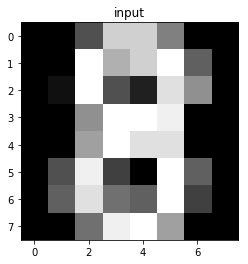

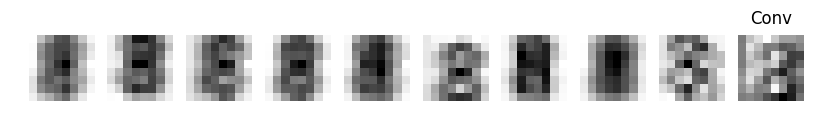

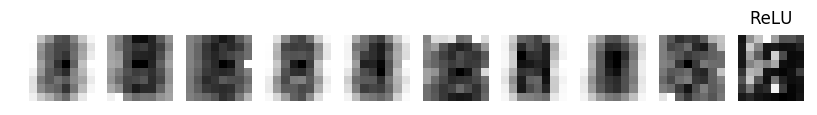

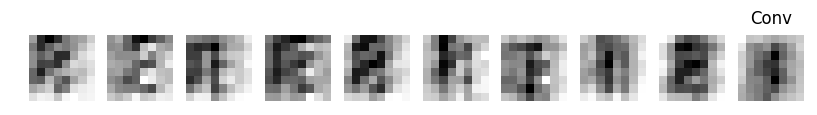

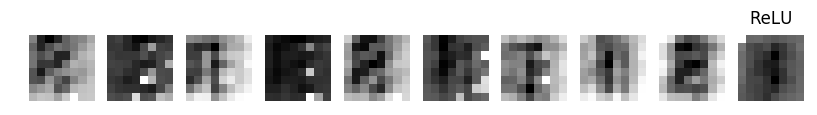

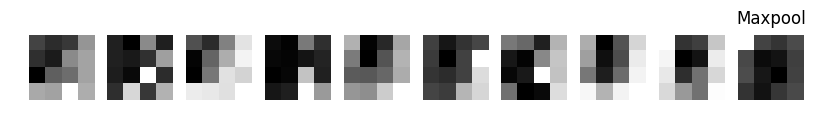

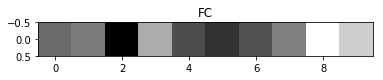

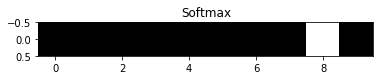

In [190]:
orginal = X_train[121]
plt.imshow(orginal[:, :, 0], cmap="gray")
plt.title("input")
plt.show()

conved = conv.graph[0].forward(orginal)
# Plot
size = conved.shape[-1]
fig = plt.figure(figsize=(size, 1), dpi=100)
for i in range(size):
    ax = fig.add_subplot(1,size,i+1)
    ax.matshow(conved[:, :, i], cmap='gray') 
    ax.axis('off')
plt.title("Conv")
plt.show()

relued = conv.graph[1].forward(conved)
# Plot
size = relued.shape[-1]
fig = plt.figure(figsize=(size, 1), dpi=100)
for i in range(size):
    ax = fig.add_subplot(1,size,i+1)
    ax.matshow(relued[:, :, i], cmap='gray') 
    ax.axis('off')
plt.title("ReLU")
plt.show()

conved = conv.graph[2].forward(relued)
# Plot
size = conved.shape[-1]
fig = plt.figure(figsize=(size, 1), dpi=100)
for i in range(size):
    ax = fig.add_subplot(1,size,i+1)
    ax.matshow(conved[:, :, i], cmap='gray') 
    ax.axis('off')
plt.title("Conv")
plt.show()

relued = conv.graph[3].forward(conved)
# Plot
size = relued.shape[-1]
fig = plt.figure(figsize=(size, 1), dpi=100)
for i in range(size):
    ax = fig.add_subplot(1,size,i+1)
    ax.matshow(relued[:, :, i], cmap='gray') 
    ax.axis('off')
plt.title("ReLU")
plt.show()

maxed = conv.graph[4].forward(relued)
# Plot
size = maxed.shape[-1]
fig = plt.figure(figsize=(size, 1), dpi=100)
for i in range(size):
    ax = fig.add_subplot(1,size,i+1)
    ax.matshow(maxed[:, :, i], cmap='gray') 
    ax.axis('off')
plt.title("Maxpool")
plt.show()

full = conv.graph[5].forward(maxed)
plt.imshow(full[0, :, :], cmap="gray")
plt.title("FC")
plt.show()

acted = conv.graph[6].forward(full)
plt.imshow(acted[0, :, :], cmap="gray")
plt.title("Softmax")
plt.show()

### INTENSE Hand debugging (no need to look further for studying purposes) 

In [47]:
assert isDebugging

AssertionError: 

#### conv layer

In [ ]:
in1 = np.array([5,6,0,8,9,0,0,0,0])
in2 = np.array([5,4,0,2,1,0,0,0,0])

In [ ]:
k1 = - np.array(range(1,10))
k2 = - np.array(range(9, 0, -1))
b1 = 1
b2 = 0

In [ ]:
print k1, k2

In [ ]:
print np.dot(k1, in1) + np.dot(k1, in2) + b1
print np.dot(k2, in1) + np.dot(k2, in2) + b2

#### Leaky ReLU

#### Maxpool

In [ ]:
max_in1 = np.array([-27.9, -23.9, -15.9, -11.9])
max_in2 = np.array([-12.0, -16.0, -24.0, -28.0])

In [ ]:
max_k1 = - np.array([0.02,0.04,0.06,0.08])
max_k2 = - np.array([0.07,0.05,0.03,0.01])
max_b = 1

In [ ]:
print max_k1, max_k2

In [ ]:
print np.dot(max_k1, max_in1) + np.dot(max_k1, max_in2) + max_b
print np.dot(max_k2, max_in1) + np.dot(max_k2, max_in2) + max_b

#### Softmax

In [ ]:
e1 = np.exp(8.98)
e2 = np.exp(7.384)
print e1, e2
e12 = e1 + e2

In [ ]:
print e1 / e12
print e2 / e12

### backward

#### softmax

In [ ]:
error  = [e1 / e12 - 0, e2 / e12 - 1]

In [ ]:
print error

#### FC

In [ ]:
fc_in_grad_1 = max_k1 * error[0] + max_k2 * error[1]
fc_in_grad_2 = max_k1 * error[0] + max_k2 * error[1]

In [ ]:
print fc_in_grad_1

#### maxpool

In [ ]:
max_in_grad = np.array([[[0.04157293, 0.04157293], [0, 0], [0.00831459, 0.00831459]], [[0, 0],[0, 0],[0, 0]],[[-0.02494376, -0.02494376],[0, 0],[-0.0582021, -0.0582021]]])

In [ ]:
print max_in_grad[:,:,0]

#### Leaky ReLU

In [ ]:
relu_grad = np.array([[[1.0, 1.0], [0, 0], [1.0, 1.0]], [[0, 0],[0, 0],[0, 0]],[[-0.1, -0.1],[0, 0],[-0.1, -0.1]]])

In [ ]:
print relu_grad[:,:,0]

#### Conv

## Machine run

In [ ]:
kernal_conv = np.array([[[[-1.0, -9.0],[-1.0, -9.0]],[[-2.0, -8.0],[-2.0, -8.0]],[[-3.0, -7.0],[-3.0, -7.0]]],[[[-4.0, -6.0],[-4.0, -6.0]],[[-5.0, -5.0],[-5.0, -5.0]],[[-6.0, -4.0],[-6.0, -4.0]]],[[[-7.0, -3.0],[-7.0, -3.0]],[[-8.0, -2.0],[-8.0, -2.0]],[[-9.0, -1.0],[-9.0, -1.0]]]])
b_conv = np.array([1.0,0.0])
kernal_fc = np.array([[[[-0.02, -0.07],[-0.02, -0.07]], [[-0.04, -0.05],[-0.04, -0.05]]], [[[-0.06, -0.03],[-0.06, -0.03]], [[-0.08, -0.01],[-0.08, -0.01]]]])
b_fc = np.array([1.0])


In [ ]:
class ConvNetForDebugging(object):
    def __init__(self):
        self.graph = [ConvolutionalLayer(kernal_conv, b_conv, 1, 1),\
                      Leaky_ReLU(),\
                      MaxpoolingLayer(2, 1),\
                      FullyConnnectedLayer(kernal_fc, b_fc, 1), \
                      SoftmaxLayer()
                    ]
        
        print "Computation graph ready."
        print ""
      
    def get_nb_of_params(self):
        nb_of_params = 0
        for n in self.graph:
            nb_of_params += n.get_nb_of_params()
        return nb_of_params
    
    def get_nb_of_layers(self):
        return len(self.graph)
    
    def get_graph_repr(self):
        res = "(input)"
        for n in self.graph:
            res += "-->" + str(n)
        res += "-->(output)"
        return res
    
    def forward(self, X):
        Z = X
        for n in self.graph:
            Z = n.forward(Z)
        return Z
    
    def get_cost(self, Y, T):
        return self.graph[-1].get_cost(Y, T)
    
    def backward(self, Y, T):
        Z = Y
        for n in reversed(self.graph):
            if str(n) == "(Softmax)":
                Z = n.backward(Z, T)
            else:
                Z = n.backward(Z)
        return Z
    
    def update_all(self, lr):
        global momentum
        momentum = 0.0
        for n in self.graph:
            n.update_all(lr)
            
    
    def print_info(self):
        print "Total number of parameters: " + repr(self.get_nb_of_params())
        print "Total number of layers: " + repr(self.get_nb_of_layers())
        print "Graph: " + repr(self.get_graph_repr())
        

In [ ]:
conv_d = ConvNetForDebugging()

In [ ]:
in1 = np.array([1,2,3,4,5,6,7,8,9])
in2 = np.array([9,8,7,6,5,4,3,2,1])

In [ ]:
in1 = np.reshape(in1, (3,3))
in2 = np.reshape(in2, (3,3))
in12 = np.dstack([in1, in2])

In [ ]:
conv_d.forward(in12)

In [ ]:
orginal = in12
conved = conv_d.graph[0].forward(orginal)
relued = conv_d.graph[1].forward(conved)
maxed = conv_d.graph[2].forward(relued)
full = conv_d.graph[3].forward(maxed)
acted = conv_d.graph[4].forward(full)
print acted

In [ ]:
T = np.array([[[0.0, 1.0]]])

In [ ]:
acted_e = conv_d.graph[4].backward(acted, T)
full_e = conv_d.graph[3].backward(acted_e)
maxed_e = conv_d.graph[2].backward(full_e)
relued_e = conv_d.graph[1].backward(maxed_e)
conved_e = conv_d.graph[0].backward(relued_e)

In [ ]:
print maxed_e[:,:,1]
print relued_e[:,:,1]